## Desafío 3, One hit wonders.

#### Grupo 1

Marcelo Beguisristain beguiris@yahoo.com.ar

Santiago Caraballo santiagocaraballo@gmail.com

Francisco Cossavella franciscocossavella@gmail.com

Maximiliano Zavala maximilian.zvl@gmail.com


## Objetivo

Consultados por una importante discográfica, necesitamos consturir un modelo que le permita a la empresa determinar qué artistas firmar.
Para hacerlo, quieren poder predecir si esos artistas tienen canciones que puedan convertirse en hits o no.
Para responder a esta pregunta, nos proponemos construir un modelo a partir de datos de Spotify que ya están clasificados como hits o misses.

### Importación de librerías:

In [715]:
import pandas as pd
import numpy as np

# modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# gráficos
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr

plt.rcParams['savefig.bbox'] = "tight"
style.use('dark_background') or plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")

In [716]:
data = pd.read_csv('dataset-of-10s.csv')
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [717]:
print(f'Tenemos {data.shape[1]} features y {data.shape[0]} observaciones')

Tenemos 19 features y 6398 observaciones


In [718]:
data.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

## Características de los datos

Spotify recolecta mucha información de la música contenida en su plataforma y, en la api de Spotify podemos ver que nuestros features representan:

track: nombre de la pieza.

artist: nombre del artista.

uri: código identificador de Spotify para esa pieza.

danceability: describe qué tanto se puede bailar la pieza musical y se basa en una combinación de elementos musicales como el tempo, la estabilidad rítmica y las regularidades. Un valor de 0 es lo menos bailable y un valor de 1 es lo más bailable. Gilda es muy bailable, Stockhausen no tanto.

energía: una medida de intensidad y actividad, describe música que suele ser fuerte, rápida y ruidosa. Un valor de cero tiene baja energía y uno de 1 tiene alta. Meshuggah tiene alta energía, Arvo Part, no.

key: es la tonalidad de la pieza, va de 1 a 12 siendo C = 1, C# = 2, etc.

loudness: los valores de volumen en db, suelen ir de -60 a 0.

mode: 1 para piezas mayores y 0 para piezas menores.

speachiness: detecta la presencia de palabra hablada. Valores por arriba de 0.66 representan piezas que son casi exclusivamente palabra hablada.

acousticness: una medida de confianza sobre si la pieza es acústica o eléctrica.

instrumentalness: predictor de que la pieza es instrumental.

liveness: detecta la presencia de público en la grabación.

valence: una medida de qué tan positiva o negativa es la pieza, valores cercanos a 1 son muy positivos, valores cercanos a 0 son negativos. es una combinación de tempo, modo, tonalidad y liveness. 

tempo: el tempo que prepondera en la pieza en BPM.

duration_ms: la duración del tema.

time_signature:	una estimación de la métrica que prepondera en la pieza.

chorus_hit:	una medida de aproximadamente cuándo comienza el estribillo de la pieza.

sections: cantidad de secciones que tiene la pieza.

target: variable dicotómica que indica si la pieza fue incluida en el Hot 100 de Billboard en algún momento durante la década comprendida en el dataset.

Además, nos gustaría tener datos del género que más se identifica con el artista así que vamos a incorporar otro dataset de donde obtener esa información.

In [719]:
data_genres = pd.read_csv('data_by_artist_o.csv')
data_genres.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [720]:
# mergeamos usando artista como clave
data_new = pd.merge(data, data_genres[['artists', 'genres']], left_on='artist', right_on='artists')
# removemos los corchetes
data_new.genres = data_new.genres.str.strip('[]')
# nos quedamos con el primer género
data_new.genres = data_new.genres.str.split(',').str.get(0)
# miramos la cuenta de valores
data_new.genres.value_counts()

'contemporary country'      545
'dance pop'                 410
'pop'                        97
'alternative metal'          94
'atl hip hop'                90
                           ... 
'cumbia andina mexicana'      1
'drum and bass'               1
'mariachi'                    1
'double drumming'             1
'funk'                        1
Name: genres, Length: 317, dtype: int64

In [721]:
data.dtypes

track                object
artist               object
uri                  object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
dtype: object

In [722]:
sns.color_palette('rocket')

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [723]:
sns.color_palette('twilight_shifted')

[(0.36002681809096376, 0.20694122817889948, 0.6029284543191687),
 (0.4113541469730457, 0.5368485776500593, 0.7466971285506578),
 (0.7387377170049494, 0.7959766573503101, 0.8214292278043301),
 (0.8398783988412087, 0.7603990719977968, 0.7136714781112923),
 (0.7387914002459927, 0.4205367299231533, 0.34913260148542435),
 (0.4981443546207415, 0.13569380302451714, 0.314135190862664)]

In [724]:
pal_1 = sns.color_palette('rocket')
print(pal_1.as_hex())

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


In [725]:
pal_2 = sns.color_palette('twilight_shifted')
print(pal_2.as_hex())

['#5c359a', '#6989be', '#bccbd1', '#d6c2b6', '#bc6b59', '#7f2350']


In [726]:
pal = ['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f', '#5c359a', '#6989be', '#bccbd1', '#d6c2b6', '#bc6b59', '#7f2350']

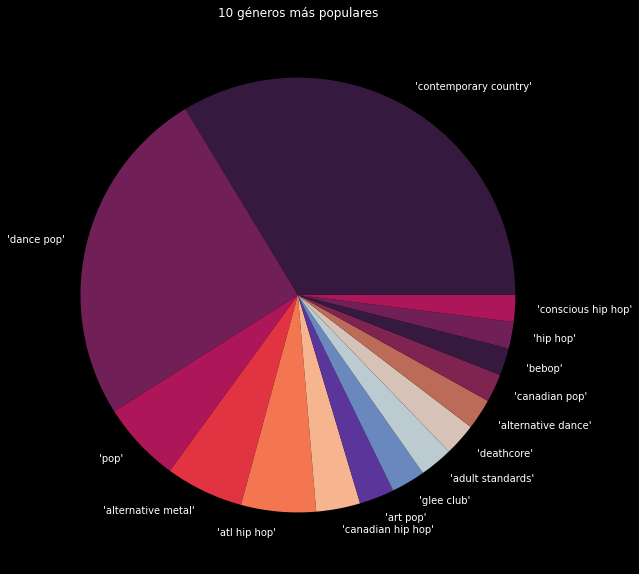

In [727]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
data_new.genres.value_counts()[:15].plot(ax=ax, kind = "pie", colors=pal)
ax.set_ylabel("")
ax.set_title('10 géneros más populares')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()

Evidentemente nuestros géneros están bastante desbalanceados y la verdad que los que entran en el top 10 son géneros súper específicos que tal vez no sean representativos, vamos a mirar con más detalle cuánto a aparece cada género.

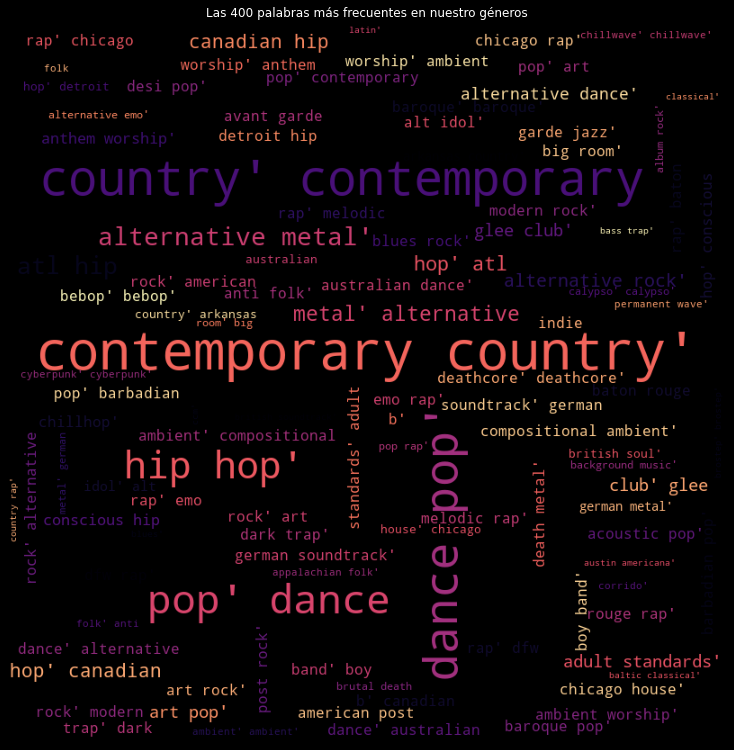

<Figure size 432x288 with 0 Axes>

In [728]:
max_words = 400
wordcloud = WordCloud(width = 800, height = 800, max_words = max_words, colormap="magma",
                min_font_size = 10).generate(" ".join(data_new.genres))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Las {max_words} palabras más frecuentes en nuestro géneros")
plt.show();

Acá se vuelve a ver que hay géneros que están sobrerepresentados, hay géneros redundantes y también vemos que muchos comparten palabras como pop, country, hip-hop.

Vamos a definir un conjunto de géneros menor que representen éstos y mapear los géneros viejos a los nuevos, para esto necesitamos tener bastante conocimiento de dominio porque hay muchos géneros cuya cateogoría superordinada no es particularmente clara.

In [729]:
genres = data_new.genres

In [730]:
genres.loc[genres.str.contains('pop') == True] = 'pop'
genres.value_counts()

pop                       773
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'experimental'              1
'bubblegrunge'              1
'atlanta metal'             1
'christian punk'            1
'country'                   1
Name: genres, Length: 271, dtype: int64

In [731]:
genres.loc[genres.str.contains('glee club') == True] = 'pop'
genres.value_counts()

pop                       814
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'chilena'                   1
'art punk'                  1
'double drumming'           1
'norteno'                   1
'christian punk'            1
Name: genres, Length: 270, dtype: int64

In [732]:
genres.loc[genres.str.contains('boy band') == True] = 'pop'
genres.value_counts()

pop                       843
'contemporary country'    545
'alternative metal'        94
'atl hip hop'              90
'canadian hip hop'         53
                         ... 
'garage rock'               1
'deep talent show'          1
'british folk'              1
'drum and bass'             1
'christian punk'            1
Name: genres, Length: 269, dtype: int64

In [733]:
genres.loc[genres.str.contains('hip hop') == True] = 'hip hop'
genres.value_counts()

pop                         843
'contemporary country'      545
hip hop                     280
'alternative metal'          94
'adult standards'            40
                           ... 
'double drumming'             1
'glam metal'                  1
'latin christian'             1
'canadian post-hardcore'      1
'british folk'                1
Name: genres, Length: 253, dtype: int64

In [734]:
genres.loc[genres.str.contains('country') == True] = 'country'
genres.value_counts()

pop                          843
country                      607
hip hop                      280
'alternative metal'           94
'adult standards'             40
                            ... 
'atl trap'                     1
'athens indie'                 1
'latin talent show'            1
'chicago punk'                 1
'contemporary vocal jazz'      1
Name: genres, Length: 244, dtype: int64

In [735]:
genres.loc[genres.str.contains('rock') == True] = 'rock'
genres.value_counts()

pop                          843
country                      607
hip hop                      280
rock                         158
'alternative metal'           94
                            ... 
'glam metal'                   1
'latin christian'              1
'canadian post-hardcore'       1
'kirtan'                       1
'contemporary vocal jazz'      1
Name: genres, Length: 223, dtype: int64

In [736]:
genres.loc[genres.str.contains('metal') == True] = 'metal'
genres.value_counts()

pop                    843
country                607
hip hop                280
rock                   158
metal                  145
                      ... 
'canadian hardcore'      1
'australian psych'       1
'norteno'                1
'art punk'               1
'deep talent show'       1
Name: genres, Length: 208, dtype: int64

In [737]:
genres.loc[genres.str.contains('deathcore') == True] = 'metal'
genres.value_counts()

pop                    843
country                607
hip hop                280
metal                  184
rock                   158
                      ... 
'alabama rap'            1
'canadian hardcore'      1
'australian psych'       1
'norteno'                1
'deep talent show'       1
Name: genres, Length: 207, dtype: int64

In [738]:
genres.loc[genres.str.contains('rap') == True] = 'rap'
genres.value_counts()

pop                          843
country                      607
hip hop                      280
rap                          195
metal                        184
                            ... 
'electro'                      1
'chilena'                      1
'contemporary vocal jazz'      1
'drum and bass'                1
'gabba'                        1
Name: genres, Length: 186, dtype: int64

In [739]:
genres.loc[genres.str.contains('dance') == True] = 'dance'
genres.value_counts()

pop                    843
country                607
hip hop                280
rap                    195
metal                  184
                      ... 
'french shoegaze'        1
'canadian hardcore'      1
'australian psych'       1
'norteno'                1
'deep talent show'       1
Name: genres, Length: 182, dtype: int64

In [740]:
genres.loc[genres.str.contains('disco') == True] = 'dance'
genres.value_counts()

pop                    843
country                607
hip hop                280
rap                    195
metal                  184
                      ... 
'french shoegaze'        1
'canadian hardcore'      1
'australian psych'       1
'norteno'                1
'deep talent show'       1
Name: genres, Length: 179, dtype: int64

In [741]:
genres.loc[genres.str.contains('house') == True] = 'dance'
genres.value_counts()

pop                 843
country             607
hip hop             280
rap                 195
metal               184
                   ... 
'future bass'         1
'acid trance'         1
'gabba'               1
'christian punk'      1
'jazz trio'           1
Name: genres, Length: 175, dtype: int64

In [742]:
genres.loc[genres.str.contains('big room') == True] = 'dance'
genres.value_counts()

pop                    843
country                607
hip hop                280
rap                    195
metal                  184
                      ... 
'experimental'           1
'chilena'                1
'japanese chillhop'      1
'double drumming'        1
'jazz trio'              1
Name: genres, Length: 174, dtype: int64

In [743]:
genres.loc[genres.str.contains('r&b') == True] = 'r&b'
genres.value_counts()

pop               843
country           607
hip hop           280
rap               195
metal             184
                 ... 
'experimental'      1
'cumbia'            1
'chilena'           1
'gabba'             1
'yoga'              1
Name: genres, Length: 173, dtype: int64

In [744]:
genres.loc[genres.str.contains('punk') == True] = 'punk'
genres.value_counts()

pop                   843
country               607
hip hop               280
rap                   195
metal                 184
                     ... 
'acid trance'           1
'gabba'                 1
'drum and bass'         1
'electro'               1
'deep talent show'      1
Name: genres, Length: 166, dtype: int64

In [745]:
genres.loc[genres.str.contains('grunge') == True] = 'punk'
genres.value_counts()

pop                   843
country               607
hip hop               280
rap                   195
metal                 184
                     ... 
'acid trance'           1
'gabba'                 1
'drum and bass'         1
'electro'               1
'deep talent show'      1
Name: genres, Length: 165, dtype: int64

In [746]:
genres.loc[genres.str.contains('folk') == True] = 'folk'
genres.value_counts()

pop                          843
country                      607
hip hop                      280
rap                          195
metal                        184
                            ... 
'ambient idm'                  1
'dubstep'                      1
'athens indie'                 1
'austro-german modernism'      1
'ballroom'                     1
Name: genres, Length: 159, dtype: int64

In [747]:
genres.loc[genres.str.contains('banjo') == True] = 'folk'
genres.value_counts()[:10]

pop                  843
country              607
hip hop              280
rap                  195
metal                184
rock                 158
dance                111
folk                  49
r&b                   48
'adult standards'     40
Name: genres, dtype: int64

In [748]:
genres.loc[genres.str.contains('singer-songwriter') == True] = 'folk'
genres.value_counts()[5:15]

rock                       158
dance                      111
folk                        50
r&b                         48
'adult standards'           40
'bebop'                     33
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [749]:
genres.loc[genres.str.contains('bluegrass') == True] = 'folk'
genres.value_counts()[5:15]

rock                       158
dance                      111
folk                        51
r&b                         48
'adult standards'           40
'bebop'                     33
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [750]:
genres.loc[genres.str.contains('jazz') == True] = 'jazz'
genres.value_counts()[5:15]

rock                       158
dance                      111
folk                        51
r&b                         48
'adult standards'           40
'bebop'                     33
'anthem worship'            32
jazz                        30
punk                        30
'compositional ambient'     28
Name: genres, dtype: int64

In [751]:
genres.loc[genres.str.contains('bop') == True] = 'jazz'
genres.value_counts()[5:15]

rock                       158
dance                      111
jazz                        69
folk                        51
r&b                         48
'adult standards'           40
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [752]:
genres.loc[genres.str.contains('bebop') == True] = 'jazz'
genres.value_counts()

pop                   843
country               607
hip hop               280
rap                   195
metal                 184
                     ... 
'drum and bass'         1
'deep talent show'      1
'electro'               1
'mariachi'              1
'acid trance'           1
Name: genres, Length: 149, dtype: int64

In [753]:
genres.loc[genres.str.contains('avant-garde') == True] = 'jazz'
genres.value_counts()

pop                   843
country               607
hip hop               280
rap                   195
metal                 184
                     ... 
'chicago drill'         1
'deep talent show'      1
'electro'               1
'mariachi'              1
'drum and bass'         1
Name: genres, Length: 148, dtype: int64

In [754]:
genres.loc[genres.str.contains('adult standards') == True] = 'jazz'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
                            28
'compositional ambient'     28
'baroque'                   26
Name: genres, dtype: int64

In [755]:
genres.loc[genres.str.contains('baroque') == True] = 'classical'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
classical                   26
Name: genres, dtype: int64

In [756]:
genres.loc[genres.str.contains('classical') == True] = 'classical'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
classical                   53
folk                        51
r&b                         48
'anthem worship'            32
punk                        30
'compositional ambient'     28
                            28
Name: genres, dtype: int64

In [757]:
genres.loc[genres.str.contains('chill') == True] = 'ambient'
genres.value_counts()[:15]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
classical                   53
folk                        51
r&b                         48
ambient                     41
'anthem worship'            32
punk                        30
'compositional ambient'     28
Name: genres, dtype: int64

In [758]:
genres.loc[genres.str.contains('alt') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                110
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
alternative          31
punk                 30
Name: genres, dtype: int64

In [759]:
genres.loc[genres.str.contains('alternative') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                110
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
alternative          31
punk                 30
Name: genres, dtype: int64

In [760]:
genres.loc[genres.str.contains('indie') == True] = 'alternative'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                110
alternative          58
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
punk                 30
Name: genres, dtype: int64

In [761]:
genres.loc[genres.str.contains('soundtrack') == True] = 'soundtrack'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                110
alternative          58
classical            53
folk                 51
r&b                  48
ambient              41
'anthem worship'     32
punk                 30
Name: genres, dtype: int64

In [762]:
genres.loc[genres.str.contains('epicore') == True] = 'soundtrack'
genres.value_counts()[:15]

pop                 843
country             607
hip hop             280
rap                 195
metal               184
rock                158
dance               111
jazz                110
alternative          58
classical            53
folk                 51
r&b                  48
soundtrack           44
ambient              41
'anthem worship'     32
Name: genres, dtype: int64

In [763]:
genres.loc[genres.str.contains('anthem worship') == True] = 'cristian'
genres.value_counts()[:15]

pop            843
country        607
hip hop        280
rap            195
metal          184
rock           158
dance          111
jazz           110
alternative     58
classical       53
folk            51
r&b             48
soundtrack      44
ambient         41
cristian        32
Name: genres, dtype: int64

In [764]:
data_new.loc[data_new.genres == ''] = np.NaN

In [765]:
genres.loc[genres.str.contains('banda') == True] = 'latin'
genres.value_counts()[:20]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
ambient                     41
cristian                    32
punk                        30
'compositional ambient'     28
                            28
'ambient worship'           25
'ambient'                   19
Name: genres, dtype: int64

In [766]:
genres.loc[genres.str.contains('latin') == True] = 'latin'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
ambient                     41
cristian                    32
punk                        30
'compositional ambient'     28
latin                       28
                            28
'ambient worship'           25
'ambient'                   19
'brostep'                   16
'calypso'                   14
'british soul'              12
'background music'          11
'emo'                       11
'permanent wave'            10
'corrido'                   10
'crunk'                      9
'austin americana'           9
Name: genres, dtype: int64

In [767]:
genres.loc[genres.str.contains('calypso') == True] = 'latin'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
'compositional ambient'     28
                            28
'ambient worship'           25
'ambient'                   19
'brostep'                   16
'british soul'              12
'emo'                       11
'background music'          11
'corrido'                   10
'permanent wave'            10
'crunk'                      9
'austin americana'           9
'ccm'                        8
Name: genres, dtype: int64

In [768]:
genres.loc[genres.str.contains('brostep') == True] = 'dubstep'
genres.value_counts()[:30]

pop                        843
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
                            28
'compositional ambient'     28
'ambient worship'           25
'ambient'                   19
dubstep                     16
'british soul'              12
'emo'                       11
'background music'          11
'corrido'                   10
'permanent wave'            10
'austin americana'           9
'crunk'                      9
'calming instrumental'       8
Name: genres, dtype: int64

In [769]:
genres.loc[genres.str.contains('british soul') == True] = 'pop'
genres.value_counts()[:30]

pop                        855
country                    607
hip hop                    280
rap                        195
metal                      184
rock                       158
dance                      111
jazz                       110
alternative                 58
classical                   53
folk                        51
r&b                         48
soundtrack                  44
latin                       42
ambient                     41
cristian                    32
punk                        30
'compositional ambient'     28
                            28
'ambient worship'           25
'ambient'                   19
dubstep                     16
'background music'          11
'emo'                       11
'permanent wave'            10
'corrido'                   10
'crunk'                      9
'austin americana'           9
'calming instrumental'       8
'ccm'                        8
Name: genres, dtype: int64

In [770]:
genres.loc[genres.str.contains('ambient') == True] = 'ambient'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      158
ambient                   114
dance                     111
jazz                      110
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'background music'         11
'emo'                      11
'permanent wave'           10
'corrido'                  10
'crunk'                     9
'austin americana'          9
'ccm'                       8
'calming instrumental'      8
'neo mellow'                7
'downtempo'                 7
'comic'                     6
Name: genres, dtype: int64

In [771]:
genres.loc[genres.str.contains('background music') == True] = 'ambient'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      158
ambient                   125
dance                     111
jazz                      110
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'emo'                      11
'corrido'                  10
'permanent wave'           10
'austin americana'          9
'crunk'                     9
'ccm'                       8
'calming instrumental'      8
'neo mellow'                7
'downtempo'                 7
'blues'                     6
'modern blues'              6
Name: genres, dtype: int64

In [772]:
genres.loc[genres.str.contains('emo') == True] = 'rock'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      169
ambient                   125
dance                     111
jazz                      110
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'corrido'                  10
'permanent wave'           10
'crunk'                     9
'austin americana'          9
'ccm'                       8
'calming instrumental'      8
'neo mellow'                7
'downtempo'                 7
'afrofuturism'              6
'comic'                     6
'atmosphere'                6
Name: genres, dtype: int64

In [773]:
genres.loc[genres.str.contains('permanent wave') == True] = 'rock'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      110
alternative                58
classical                  53
folk                       51
r&b                        48
soundtrack                 44
latin                      42
cristian                   32
punk                       30
                           28
dubstep                    16
'corrido'                  10
'crunk'                     9
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'neo mellow'                7
'downtempo'                 7
'afrofuturism'              6
'blues'                     6
'comic'                     6
'atmosphere'                6
Name: genres, dtype: int64

In [774]:
genres.loc[genres.str.contains('corrido') == True] = 'latin'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       195
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      110
alternative                58
classical                  53
latin                      52
folk                       51
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'crunk'                     9
'austin americana'          9
'ccm'                       8
'calming instrumental'      8
'downtempo'                 7
'neo mellow'                7
'blues'                     6
'atmosphere'                6
'comic'                     6
'afrofuturism'              6
'modern blues'              6
Name: genres, dtype: int64

In [775]:
genres.loc[genres.str.contains('crunk') == True] = 'rap'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       204
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      110
alternative                58
classical                  53
latin                      52
folk                       51
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'austin americana'          9
'calming instrumental'      8
'ccm'                       8
'downtempo'                 7
'neo mellow'                7
'atmosphere'                6
'comic'                     6
'afrofuturism'              6
'modern blues'              6
'electronica'               6
'blues'                     6
Name: genres, dtype: int64

In [776]:
genres.loc[genres.str.contains('austin americana') == True] = 'folk'
genres.value_counts()[:30]

pop                       855
country                   607
hip hop                   280
rap                       204
metal                     184
rock                      179
ambient                   125
dance                     111
jazz                      110
folk                       60
alternative                58
classical                  53
latin                      52
r&b                        48
soundtrack                 44
cristian                   32
punk                       30
                           28
dubstep                    16
'ccm'                       8
'calming instrumental'      8
'neo mellow'                7
'downtempo'                 7
'modern blues'              6
'afrofuturism'              6
'atmosphere'                6
'electronica'               6
'blues'                     6
'comic'                     6
'bachata'                   5
Name: genres, dtype: int64

In [777]:
genres.loc[genres.str.contains('calming instrumental') == True] = 'ambient'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             111
jazz              110
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'downtempo'         7
'neo mellow'        7
'afrofuturism'      6
'blues'             6
'atmosphere'        6
'modern blues'      6
'electronica'       6
'comic'             6
'djent'             5
'bachata'           5
Name: genres, dtype: int64

In [778]:
genres.loc[genres.str.contains('cmm') == True] = 'cristian'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             111
jazz              110
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'downtempo'         7
'neo mellow'        7
'afrofuturism'      6
'blues'             6
'atmosphere'        6
'modern blues'      6
'electronica'       6
'comic'             6
'djent'             5
'bachata'           5
Name: genres, dtype: int64

In [779]:
genres.loc[genres.str.contains('downtempo') == True] = 'dance'
genres.value_counts()[:30]

pop               855
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             118
jazz              110
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'neo mellow'        7
'modern blues'      6
'blues'             6
'comic'             6
'atmosphere'        6
'electronica'       6
'afrofuturism'      6
'djent'             5
'nu-cumbia'         5
'bachata'           5
Name: genres, dtype: int64

In [780]:
genres.loc[genres.str.contains('neo mellow') == True] = 'pop'
genres.value_counts()[:30]

pop                   862
country               607
hip hop               280
rap                   204
metal                 184
rock                  179
ambient               133
dance                 118
jazz                  110
folk                   60
alternative            58
classical              53
latin                  52
r&b                    48
soundtrack             44
cristian               32
punk                   30
                       28
dubstep                16
'ccm'                   8
'blues'                 6
'afrofuturism'          6
'atmosphere'            6
'electronica'           6
'modern blues'          6
'comic'                 6
'djent'                 5
'nu-cumbia'             5
'bachata'               5
'anglican liturgy'      4
Name: genres, dtype: int64

In [781]:
genres.loc[genres.str.contains('afrofuturism') == True] = 'jazz'
genres.value_counts()[:30]

pop               862
country           607
hip hop           280
rap               204
metal             184
rock              179
ambient           133
dance             118
jazz              116
folk               60
alternative        58
classical          53
latin              52
r&b                48
soundtrack         44
cristian           32
punk               30
                   28
dubstep            16
'ccm'               8
'comic'             6
'blues'             6
'modern blues'      6
'atmosphere'        6
'electronica'       6
'djent'             5
'bachata'           5
'nu-cumbia'         5
'bossa nova'        4
'dreamo'            4
Name: genres, dtype: int64

In [782]:
genres.loc[genres.str.contains('blues') == True] = 'blues'
genres.value_counts()[:30]

pop                 862
country             607
hip hop             280
rap                 204
metal               184
rock                179
ambient             133
dance               118
jazz                116
folk                 60
alternative          58
classical            53
latin                52
r&b                  48
soundtrack           44
cristian             32
punk                 30
                     28
dubstep              16
blues                15
'ccm'                 8
'electronica'         6
'atmosphere'          6
'comic'               6
'nu-cumbia'           5
'bachata'             5
'djent'               5
'easy listening'      4
'complextro'          4
'lo-fi beats'         4
Name: genres, dtype: int64

In [783]:
genres.loc[genres.str.contains('electronica') == True] = 'dance'
genres.value_counts()[:30]

pop             862
country         607
hip hop         280
rap             204
metal           184
rock            179
ambient         133
dance           124
jazz            116
folk             60
alternative      58
classical        53
latin            52
r&b              48
soundtrack       44
cristian         32
punk             30
                 28
dubstep          16
blues            15
'ccm'             8
'comic'           6
'atmosphere'      6
'bachata'         5
'djent'           5
'nu-cumbia'       5
'dreamo'          4
'bboy'            4
'hollywood'       4
'complextro'      4
Name: genres, dtype: int64

In [784]:
genres.loc[genres.str.contains('atmosphere') == True] = 'ambient'
genres.value_counts()[:30]

pop              862
country          607
hip hop          280
rap              204
metal            184
rock             179
ambient          139
dance            124
jazz             116
folk              60
alternative       58
classical         53
latin             52
r&b               48
soundtrack        44
cristian          32
punk              30
                  28
dubstep           16
blues             15
'ccm'              8
'comic'            6
'nu-cumbia'        5
'djent'            5
'bachata'          5
'a cappella'       4
'complextro'       4
'bboy'             4
'hollywood'        4
'lo-fi beats'      4
Name: genres, dtype: int64

In [785]:
genres.loc[genres.str.contains('bachata') == True] = 'latin'
genres.value_counts()[:30]

pop                      862
country                  607
hip hop                  280
rap                      204
metal                    184
rock                     179
ambient                  139
dance                    124
jazz                     116
folk                      60
alternative               58
latin                     57
classical                 53
r&b                       48
soundtrack                44
cristian                  32
punk                      30
                          28
dubstep                   16
blues                     15
'ccm'                      8
'comic'                    6
'nu-cumbia'                5
'djent'                    5
'canadian electronic'      4
'complextro'               4
'bboy'                     4
'hollywood'                4
'dreamo'                   4
'lo-fi beats'              4
Name: genres, dtype: int64

In [786]:
genres.loc[genres.str.contains('cumbia') == True] = 'latin'
genres.value_counts()[:30]

pop                 862
country             607
hip hop             280
rap                 204
metal               184
rock                179
ambient             139
dance               124
jazz                116
latin                67
folk                 60
alternative          58
classical            53
r&b                  48
soundtrack           44
cristian             32
punk                 30
                     28
dubstep              16
blues                15
'ccm'                 8
'comic'               6
'djent'               5
'easy listening'      4
'bboy'                4
'a cappella'          4
'hollywood'           4
'complextro'          4
'lo-fi beats'         4
'dreamo'              4
Name: genres, dtype: int64

In [787]:
data_new

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,artists,genres
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1.0,-4.826,0.0,0.0886,0.020000,...,0.0828,0.7060,108.029,188493.0,4.0,41.18681,10.0,1.0,Alessia Cara,r&b
1,Growing Pains,Alessia Cara,spotify:track:003eoIwxETJujVWmNFMoZy,0.353,0.755,1.0,-6.276,0.0,0.7330,0.082200,...,0.3900,0.4370,191.153,193680.0,4.0,30.59169,10.0,1.0,Alessia Cara,r&b
2,How Far I'll Go,Alessia Cara,spotify:track:1ehPJRt49h6N0LoryqKZXq,0.310,0.540,9.0,-9.629,1.0,0.3460,0.163000,...,0.0713,0.1480,180.994,175507.0,4.0,29.61999,7.0,1.0,Alessia Cara,r&b
3,Here,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,0.376,0.821,0.0,-3.974,1.0,0.1040,0.078500,...,0.0823,0.3310,120.462,199453.0,4.0,42.95002,10.0,1.0,Alessia Cara,r&b
4,Scars To Your Beautiful,Alessia Cara,spotify:track:0prNGof3XqfTvNDxHonvdK,0.573,0.739,0.0,-5.740,1.0,0.1290,0.028500,...,0.1110,0.4510,97.085,230227.0,4.0,39.64393,9.0,1.0,Alessia Cara,r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,My Obsession,Killswitch Engage,spotify:track:3x1Nt4T8cvlBCJtlmKDRAV,0.590,0.970,8.0,-3.815,1.0,0.0886,0.000047,...,0.3790,0.4230,124.998,224760.0,4.0,32.70246,10.0,0.0,Killswitch Engage,metal
3286,Paranoid Android I,Brad Mehldau,spotify:track:5Jz6iIgLRx5huCdlM8QDts,0.389,0.127,7.0,-16.157,0.0,0.0392,0.990000,...,0.1110,0.0807,74.023,101387.0,1.0,36.44766,4.0,0.0,Brad Mehldau,jazz
3287,Last Christmas,Wham!,spotify:track:6wn2nmFn3wDuiMldRiuRuL,0.757,0.618,11.0,-7.964,0.0,0.0282,0.262000,...,0.2210,0.8610,106.856,267160.0,4.0,18.19036,13.0,1.0,Wham!,pop
3288,Trash - The London Suede Version,The London Suede,spotify:track:47VqgHgXvn4Cx2RVeQq2Tk,0.439,0.993,11.0,-2.923,1.0,0.1000,0.000937,...,0.2850,0.1570,124.609,245947.0,4.0,81.97844,9.0,0.0,The London Suede,pop


In [788]:
genres

0         r&b
1         r&b
2         r&b
3         r&b
4         r&b
        ...  
3285    metal
3286     jazz
3287      pop
3288      pop
3289     rock
Name: genres, Length: 3290, dtype: object

In [789]:
data = data_new.drop(['genres'], axis=1)

In [790]:
data = pd.concat([data, genres], axis=1)
data

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,artists,genres
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1.0,-4.826,0.0,0.0886,0.020000,...,0.0828,0.7060,108.029,188493.0,4.0,41.18681,10.0,1.0,Alessia Cara,r&b
1,Growing Pains,Alessia Cara,spotify:track:003eoIwxETJujVWmNFMoZy,0.353,0.755,1.0,-6.276,0.0,0.7330,0.082200,...,0.3900,0.4370,191.153,193680.0,4.0,30.59169,10.0,1.0,Alessia Cara,r&b
2,How Far I'll Go,Alessia Cara,spotify:track:1ehPJRt49h6N0LoryqKZXq,0.310,0.540,9.0,-9.629,1.0,0.3460,0.163000,...,0.0713,0.1480,180.994,175507.0,4.0,29.61999,7.0,1.0,Alessia Cara,r&b
3,Here,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,0.376,0.821,0.0,-3.974,1.0,0.1040,0.078500,...,0.0823,0.3310,120.462,199453.0,4.0,42.95002,10.0,1.0,Alessia Cara,r&b
4,Scars To Your Beautiful,Alessia Cara,spotify:track:0prNGof3XqfTvNDxHonvdK,0.573,0.739,0.0,-5.740,1.0,0.1290,0.028500,...,0.1110,0.4510,97.085,230227.0,4.0,39.64393,9.0,1.0,Alessia Cara,r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,My Obsession,Killswitch Engage,spotify:track:3x1Nt4T8cvlBCJtlmKDRAV,0.590,0.970,8.0,-3.815,1.0,0.0886,0.000047,...,0.3790,0.4230,124.998,224760.0,4.0,32.70246,10.0,0.0,Killswitch Engage,metal
3286,Paranoid Android I,Brad Mehldau,spotify:track:5Jz6iIgLRx5huCdlM8QDts,0.389,0.127,7.0,-16.157,0.0,0.0392,0.990000,...,0.1110,0.0807,74.023,101387.0,1.0,36.44766,4.0,0.0,Brad Mehldau,jazz
3287,Last Christmas,Wham!,spotify:track:6wn2nmFn3wDuiMldRiuRuL,0.757,0.618,11.0,-7.964,0.0,0.0282,0.262000,...,0.2210,0.8610,106.856,267160.0,4.0,18.19036,13.0,1.0,Wham!,pop
3288,Trash - The London Suede Version,The London Suede,spotify:track:47VqgHgXvn4Cx2RVeQq2Tk,0.439,0.993,11.0,-2.923,1.0,0.1000,0.000937,...,0.2850,0.1570,124.609,245947.0,4.0,81.97844,9.0,0.0,The London Suede,pop


In [791]:
data = data.groupby('genres').filter(lambda x : len(x)>15)

In [792]:
remove = data.genres == ''
data = data[np.logical_not(remove)]

In [793]:
data.target.value_counts()

1.0    1928
0.0    1175
Name: target, dtype: int64

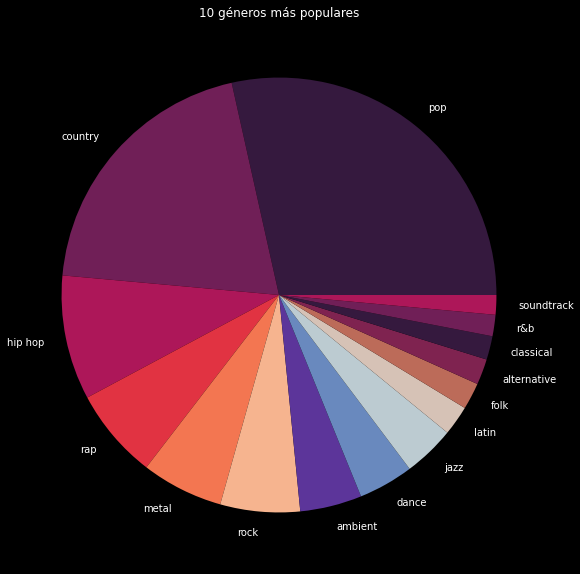

<Figure size 432x288 with 0 Axes>

In [794]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
data.genres.value_counts()[:15].plot(ax=ax, kind = "pie", colors=pal)
ax.set_ylabel("")
ax.set_title('10 géneros más populares')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()
plt.savefig('torta2.png', dpi=300, bbox_inches='tight')

Esto intuitivamente se ve mucho mejor.

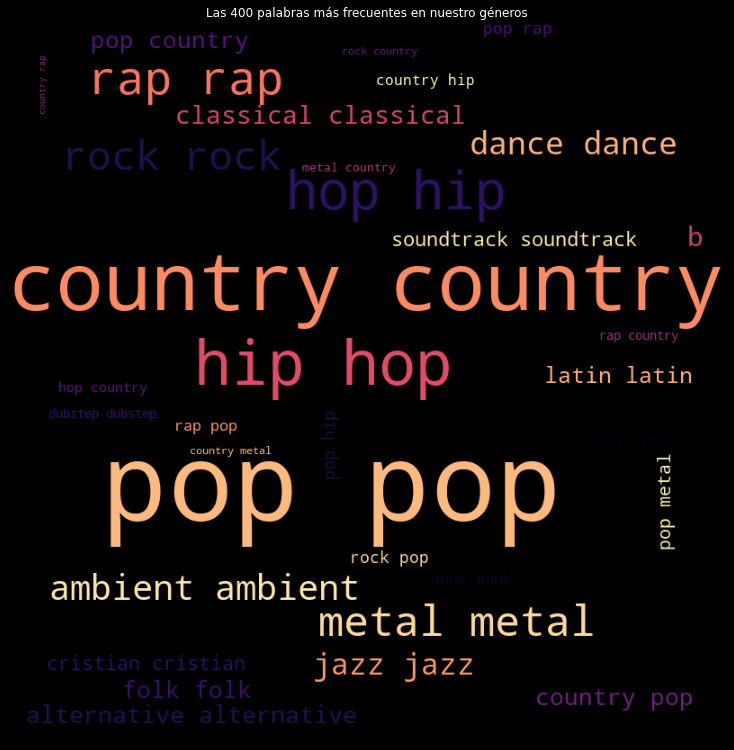

In [795]:
max_words = 400
wordcloud = WordCloud(width = 800, height = 800, max_words = max_words, colormap="magma",
                min_font_size = 10).generate(" ".join(data.genres))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"Las {max_words} palabras más frecuentes en nuestro géneros")
plt.show()

Esto se ve bastante más manejable, vamos a convertirlas en dummies.

In [796]:
genre_dummies = pd.get_dummies(data.genres, drop_first=True)
genre_dummies.head()

,ambient,classical,country,cristian,dance,dubstep,folk,hip hop,jazz,latin,metal,pop,punk,r&b,rap,rock,soundtrack
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [797]:
data_dummies = pd.concat([data, genre_dummies], axis = 1)

In [798]:
data = data_dummies.drop(['genres'], axis=1)

In [799]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,hip hop,jazz,latin,metal,pop,punk,r&b,rap,rock,soundtrack
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,...,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000
mean,0.573144,0.642941,5.221721,-7.594519,0.686110,0.085564,0.246902,0.113293,0.193849,0.461059,...,0.090235,0.037383,0.021592,0.059297,0.277796,0.009668,0.015469,0.065743,0.057686,0.014180
std,0.175846,0.240275,3.583464,5.225452,0.464147,0.089243,0.308257,0.272942,0.168650,0.243518,...,0.286565,0.189729,0.145371,0.236219,0.447984,0.097866,0.123428,0.247872,0.233187,0.118251
min,0.062500,0.000251,0.000000,-39.286000,0.000000,0.022500,0.000001,0.000000,0.019900,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.473000,0.505500,2.000000,-8.389000,0.000000,0.035500,0.017450,0.000000,0.096800,0.260000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.588000,0.691000,5.000000,-6.022000,1.000000,0.048500,0.096200,0.000004,0.122000,0.456000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.695000,0.830000,8.000000,-4.608000,1.000000,0.090050,0.375500,0.003250,0.235500,0.647000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.980000,0.998000,11.000000,-0.716000,1.000000,0.733000,0.996000,0.983000,0.980000,0.976000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Vamos a chequear datos faltantes:

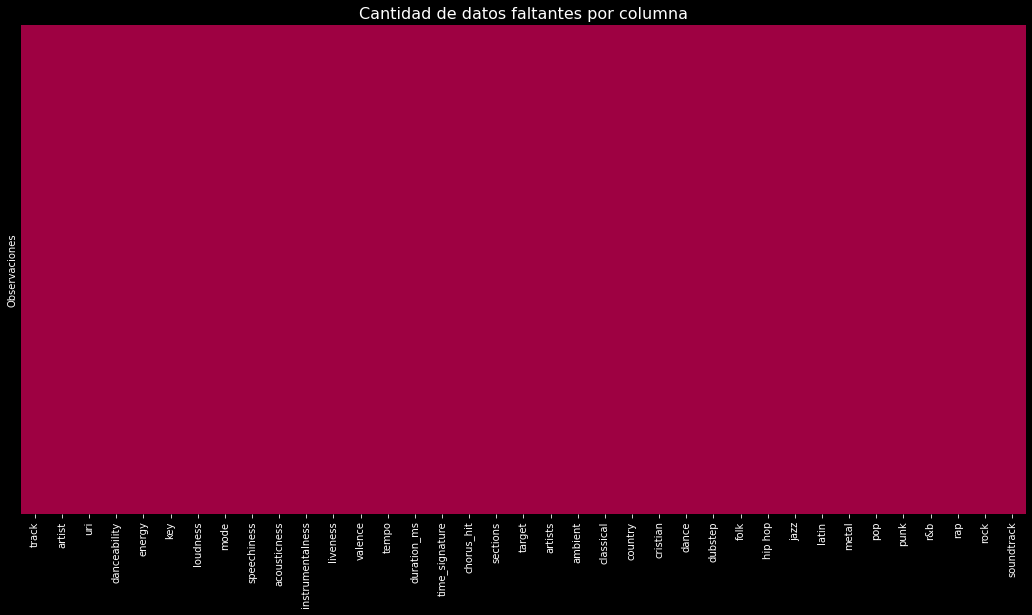

In [800]:
fig, ax = plt.subplots(figsize=(18,9))
sns.heatmap(data.isnull(), cbar=False, cmap='Spectral');
ax.set_title('Cantidad de datos faltantes por columna', fontdict={'fontsize': 16});
ax.set_ylabel('Observaciones');
ax.set_xlabel('');
ax.tick_params(labelleft=False, left=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

No tenemos NA's, vamos a ver cómo se distribuyen las variables numéricas y cómo se relacionan entre sí.

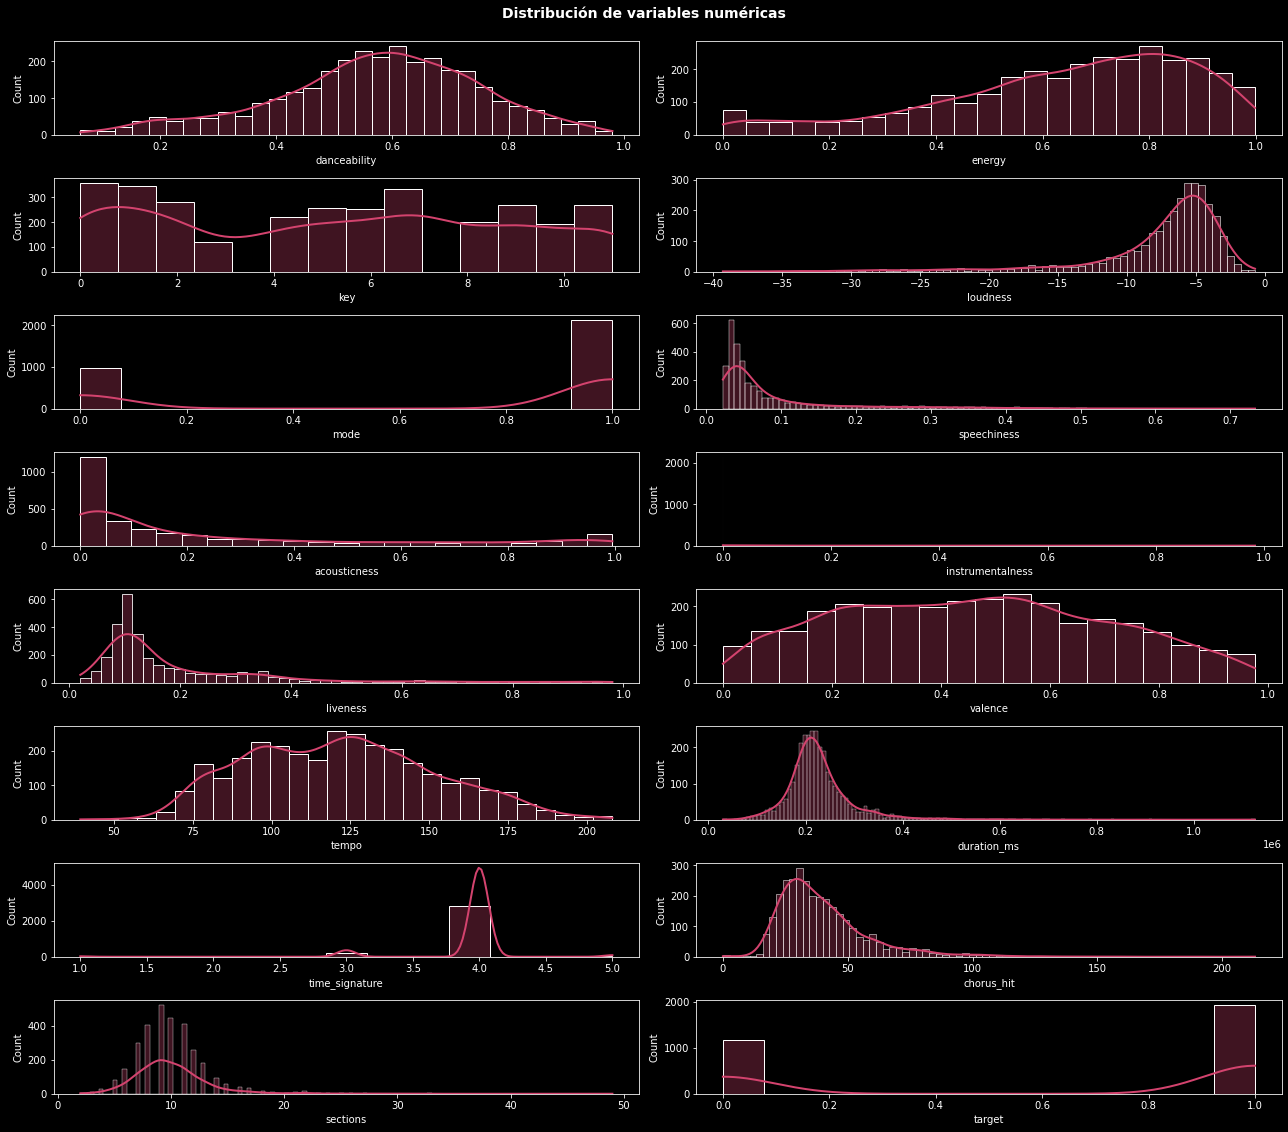

In [801]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18, 16))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = sns.color_palette('magma')[3],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )

    
fig.tight_layout()
plt.subplots_adjust(top = 0.95)
fig.suptitle('Distribución de variables numéricas', fontsize = 14, fontweight = "bold");

Las distribuciones se ven bien, es coherente que speachiness este concentrada hacia valores bajos, indicando que la mayoría de nuestras observaciones no se constituyen completamente de palabra hablada y que loudness está entre 0 y -10.

Vamos a ver las correlaciones entre nuestras variables.

In [802]:
def matrix_corr(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = data.select_dtypes(include=['float64', 'int']).corr(method='pearson')
matrix_corr(corr_matrix).head(5)

,variable_1,variable_2,r,abs_r
19,energy,loudness,0.796893,0.796893
49,loudness,energy,0.796893,0.796893
190,duration_ms,sections,0.786448,0.786448
235,sections,duration_ms,0.786448,0.786448
22,energy,acousticness,-0.761210,0.761210


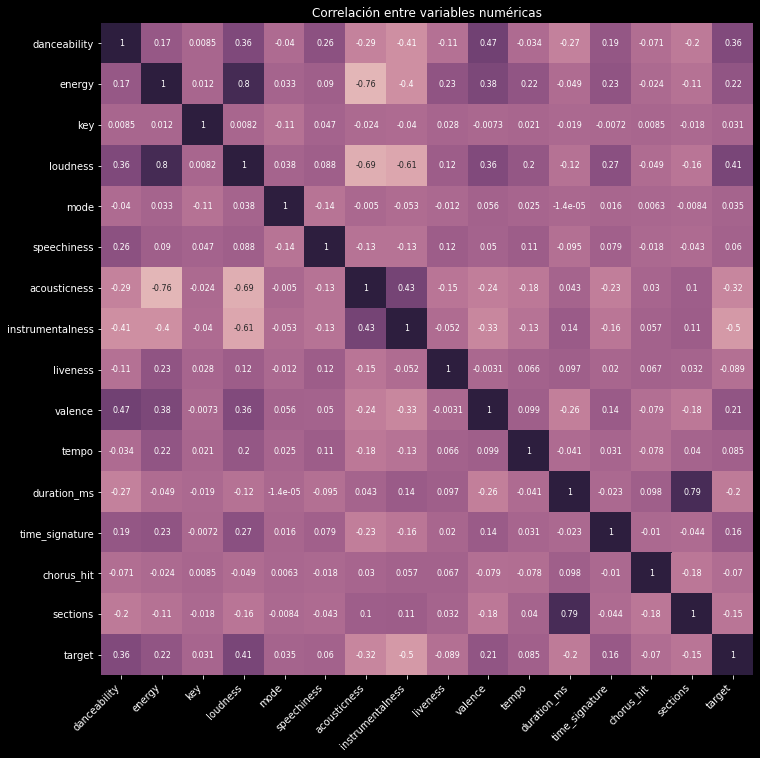

In [803]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.cubehelix_palette(as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.set_title("Correlación entre variables numéricas")
ax.tick_params(labelsize = 10)

De nuevo, dado cómo están construídas algunas de nuestras features, las correlaciones son esperables. Por ejemplo entre valence y danceability o loudness y energy. Otras son bastante flojas.

Vamos a ver el balance de nuestro target y ya podemos empezar a fitear algún modelo.

In [804]:
data.target.value_counts()

1.0    1928
0.0    1175
Name: target, dtype: int64

Está ligeramente desbalanceado; separamos nuestros features y target. 

In [805]:
X = data.drop(['target', 'artist', 'artists', 'uri', 'track'], axis=1)
y = data.target

Armamos sets de entrenamiento y testeo estratificando por nuestra variable target.

In [806]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y,
                                                stratify = y,
                                                train_size=0.8,
                                                random_state=1234)

## Bayesline

Para tener un baseline, vamos a usar un Naive Bayes.

In [807]:
gnb_model = GaussianNB()
fit = gnb_model.fit(Xtrain, ytrain)

In [808]:
ypred = gnb_model.predict(Xtest)

In [809]:
accuracy_score(ytest, ypred)

0.7391304347826086

El accuracy del primer modelo no está nada mal, vamos a ver la matriz de confusión:

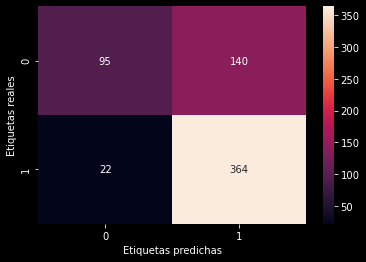

In [810]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [811]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
95 negativos verdaderos
22 negativos falsos
364 positivos verdaderos
140 positivos falsos


Este primer modelo ya se ve bastante bien, pero tenemos un leve problema con los falsos positivos y esto nos molesta particularmente porque identificar un tema como un hit podría hacer que la compañía realice una inversión grande de dinero en un artista y ésta tasa de error no nos deja del todo tranquilos.
Chequeamos la precisión, el recal y el f1:

In [812]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media ponerada de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: 
0.7222222222222222
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9430051813471503
La media ponerada de las dos medidas anteriores es 
0.8179775280898877


In [813]:
def plot_roc_curve(ytest, ypred):
    
    auc = roc_auc_score(ytest, ypred)
    false_positive_rate, true_positive_rate, thresolds = roc_curve(ytest, ypred)

    plt.figure(figsize=(12, 6))
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'purple')
    plt.fill_between(false_positive_rate, 
                     true_positive_rate, 
                     facecolor=sns.color_palette('magma')[1], 
                     alpha=0.2)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='white')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

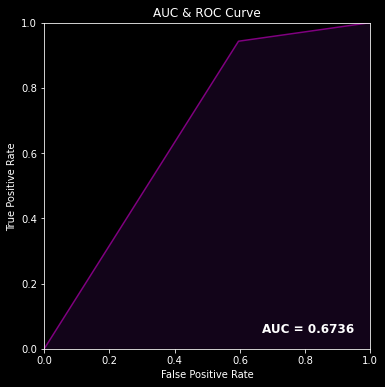

In [814]:
plot_roc_curve(ytest, ypred)

Como primer modelo es bastante aceptable, aunque el área bajo la curva no es tanto mejor que el azar. 
Vamos a probar ahora con KNN a ver si podemos mejorarlo.

## k-NN

Para calcular las distancias necesitamos escalar nuestros features de entrenamiento y le enseñamos eso a los features de testeo.

In [815]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
pd.DataFrame(Xtrain).describe().round()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,...,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0,2482.0
mean,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-3.0,-1.0,-6.0,-1.0,-1.0,-1.0,-0.0,-1.0,-2.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
25%,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
50%,0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-0.0,0.0,1.0,...,-0.0,-0.0,-0.0,-0.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0
max,2.0,1.0,2.0,1.0,1.0,7.0,2.0,3.0,5.0,2.0,...,3.0,5.0,6.0,4.0,2.0,11.0,8.0,4.0,4.0,8.0


Vamos a validar los hiperparametros de nuestro k-nn, para ello usamos una grilla para chequear hiperparámetros exhaustivamente y además, como nuestro target estaba un tanto desbalanceado, usamos un esquema de validación cruzada estratificado:

In [848]:
parameters = {'n_neighbors': np.arange(1, 22, 1), 'weights':('uniform', 'distance'), 'metric':('euclidean', 'manhattan', 'chebyshev', 'minkowski')}
scores = {'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'accuracy_score': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
knn = KNeighborsClassifier()
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
knnCV = GridSearchCV(knn, parameters, cv=folds, n_jobs=-1, scoring=scores, refit='roc_auc')

In [849]:
knnCV.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]),
                         'weights': ('uniform', 'distance')},
             refit='roc_auc',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [850]:
knnCV.best_estimator_

KNeighborsClassifier(metric='chebyshev', n_neighbors=11, weights='distance')

In [851]:
ypred = knnCV.predict(Xtest)

In [852]:
accuracy_score(ytest, ypred)

0.895330112721417

Acá el accuracy se disparó bastante, vamos a chequear la matriz de confusión.

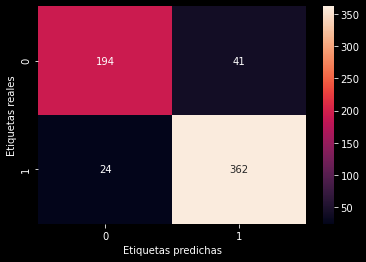

In [853]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [822]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
194 negativos verdaderos
24 negativos falsos
362 positivos verdaderos
41 positivos falsos


Miremos las probabilidades de clasificar correcta o incorrectamente los temas como hits.

In [823]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

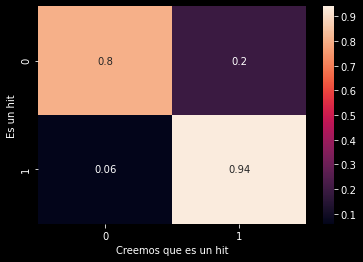

In [842]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

Las predicciones de nuestro modelo parecen ser bastante buenas, mejorar un poco el problema de los falsos positivos nos vendria bien. 

Vamos a chequear la precisión.

In [825]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media ponerada de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no lo es es: 
0.8982630272952854
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9378238341968912
La media ponerada de las dos medidas anteriores es 
0.917617237008872


In [826]:
roc_auc_score(ytest, ypred)

0.881677874545254

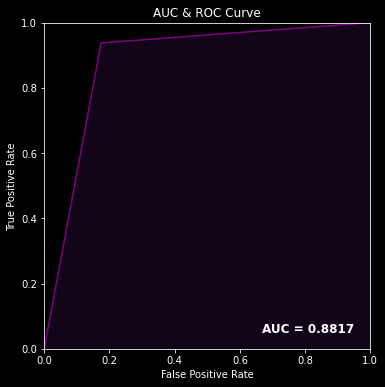

In [827]:
plot_roc_curve(ytest, ypred)

## Regresión logística

Vamos a probar con una regresión logística a ver si podemos mejorar aún más.

In [843]:
parameters = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 50)}
scores = {'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'accuracy_score': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
logit = LogisticRegression(max_iter=1000)
logitCV = GridSearchCV(logit, parameters, cv=folds, n_jobs=-1, refit='roc_auc')

In [844]:
logitCV.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1....
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             refit='roc_auc')

In [845]:
logitCV.best_estimator_

LogisticRegression(C=3.727593720314938, max_iter=1000)

In [846]:
ypred = logitCV.predict(Xtest)

In [847]:
accuracy_score(ytest, ypred)

0.8888888888888888

El accuracy baja un toque, pero vamos a chequear las matrices y el roc_auc_score.

In [833]:
ypred_prob = logitCV.predict_proba(Xtest)

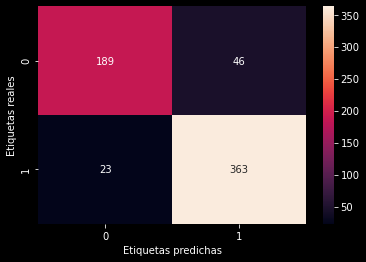

In [834]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [835]:
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print(f'Es decir que tenemos: \n{tn} negativos verdaderos')
print(f'{fn} negativos falsos')
print(f'{tp} positivos verdaderos')
print(f'{fp} positivos falsos')

Es decir que tenemos: 
189 negativos verdaderos
23 negativos falsos
363 positivos verdaderos
46 positivos falsos


In [836]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

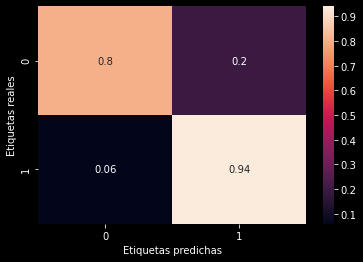

In [837]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [838]:
print(f'La capacidad de nuestro modelo para no decir que un tema es un hit cuando no es un hit es: \n{precision_score(ytest, ypred)}')
print(f'La capacidad de nuestro modelo para identificar todos los temas que son hits es: \n{recall_score(ytest, ypred)}')
print(f'La media ponerada de las dos medidas anteriores es \n{f1_score(ytest, ypred)}')

La capacidad de nuestro modelo para no decir que un tema es un hit cuando no es un hit es: 
0.8875305623471883
La capacidad de nuestro modelo para identificar todos los temas que son hits es: 
0.9404145077720207
La media ponerada de las dos medidas anteriores es 
0.9132075471698113


In [839]:
roc_auc_score(ytest, ypred)

0.8723349134604784

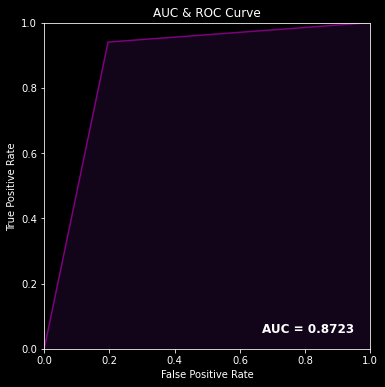

In [840]:
plot_roc_curve(ytest, ypred)

Bueno, parecería que el mejor modelo que podemos encontrar por ahora es el knn, que tiene buena performance en general.

Sin embargo, nos gustaría ir un poco más profundo ya que a la hora de incorporar nuevos artistas, a la empresa le gustaría saber en qué dirección buscar, una vez que ingresaron los temas en el modelo obtienen una buena predicción pero antes hay que saber dónde buscar los temas: 

¿Todos los géneros tienen la misma importancia?

¿Es más importante que un tema sea bailable o que tenga alta energía?

Para empezar a contestar este tipo de preguntas podemos usar una técnica que se llama permutation importance, en la que desordenamos los valores de una variable por vez y vemos cómo esto afecta el fit de nuestro modelo. La medida en la que nuestro modelo se ve perturbado por las modificaciones en una feature nos provee una métrica del grado de importancia que esa variable tiene en nuestro modelo.

Valores altos indican que esa variable tiene un impacto muy alto sobre nuestro accuracy visto que, al mezclar el orden de sus valores, éste baja considerablemente.

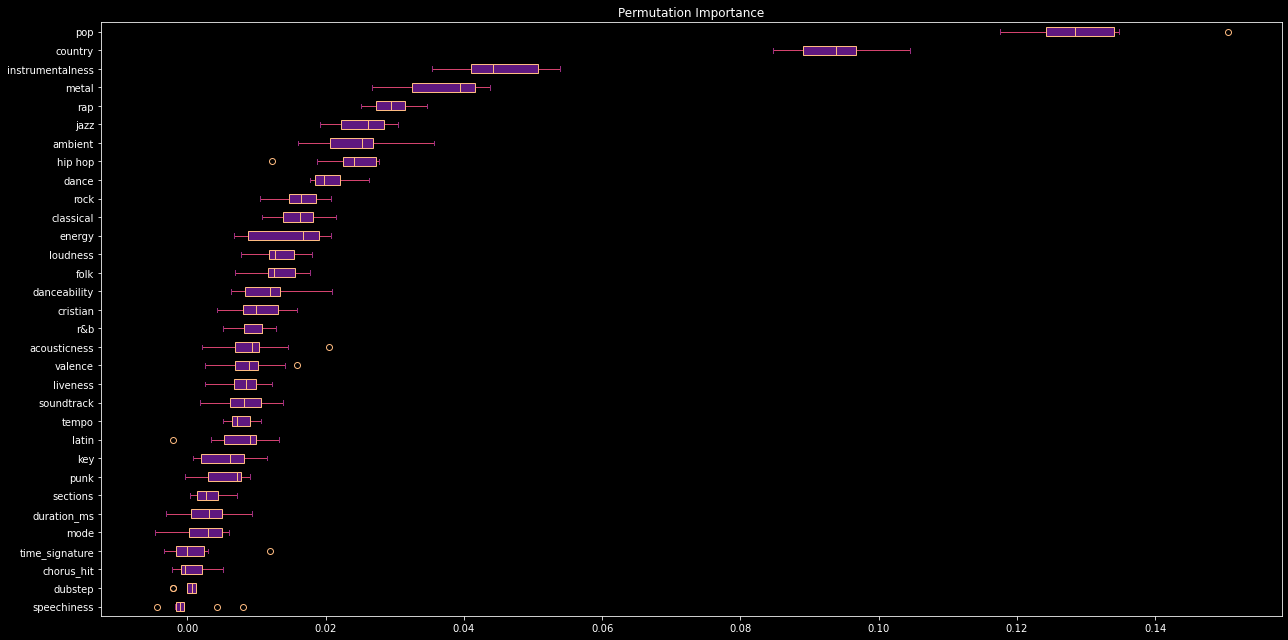

In [841]:
result = permutation_importance(knnCV, Xtest, ytest, n_repeats=10,
                               random_state=0)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(18, 9))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, 
            labels=np.array(X.columns)[sorted_idx],
            patch_artist=True,
            boxprops=dict(facecolor=sns.color_palette('magma')[1], color=sns.color_palette('magma')[5]),
            capprops=dict(color=sns.color_palette('magma')[2]),
            whiskerprops=dict(color=sns.color_palette('magma')[3]),
            flierprops=dict(color=sns.color_palette('magma')[4], markeredgecolor=sns.color_palette('magma')[5]),
            medianprops=dict(color=sns.color_palette('magma')[5]))
plt.title("Permutation Importance")
fig.tight_layout()
plt.show()

En el gráfico podemos ver cómo las variables que más importancia tienen para nuestro modelo son los géneros, específicamente los géneros que están más representados en nuestros datos, el grado de instrumentalidad, el volumen y la energía; mientras que variables como el modo, la valencia o el tempo tienen un efecto muy pequeño sobre el accuracy.